Chapter 4:Coding GPT Architecture

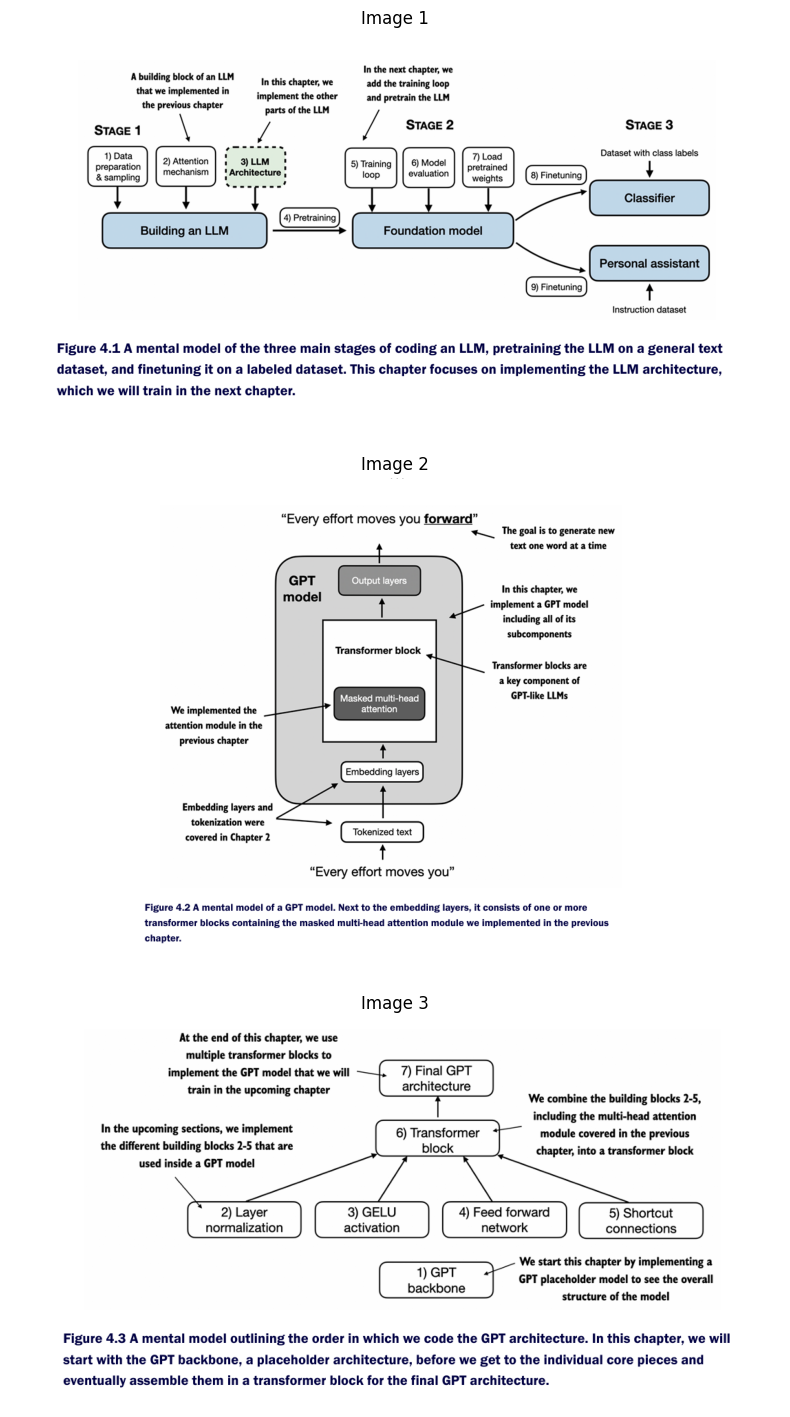

In [2]:
import matplotlib.pyplot as plt
img1 = plt.imread("images/6.png")
img2 = plt.imread("images/7.png")
img3 = plt.imread("images/8.png")
fig, axs = plt.subplots(3, 1, figsize=(8, 15))  # 3 rows, 1 column

axs[0].imshow(img1)
axs[0].axis("off")
axs[0].set_title("Image 1")

axs[1].imshow(img2)
axs[1].axis("off")
axs[1].set_title("Image 2")

axs[2].imshow(img3)
axs[2].axis("off")
axs[2].set_title("Image 3")

plt.tight_layout()
plt.show()


In [3]:
GPT_config_124M={
    "vocab_size":50257, # Vocabulary
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

# This is used as cfg in the next section , cfg means configuration  
# it will be used with the following class as ->model = DummyGPTModel(cfg=GPT_config_124M)

In [4]:
import torch 
import torch.nn as nn

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape,eps=1e-5):
        super().__init__()
    def forward(self,x):
        return x
        
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    def forward(self,x):
        return x

class DummyGPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb=nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb=nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        """Token embeddings: Each word gets a unique vector.
            Position embeddings: Each position gets a unique vector.
            Both are learnable and updated during training. The arguments just tell PyTorch how big each lookup table should be!
            """
        self.drop_emb=nn.Dropout(cfg["drop_rate"])
        self.trf_blocks=nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm=DummyLayerNorm(cfg["emb_dim"])
        self.out_head=nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)
    def forward(self,in_idx):
        batch_size,seq_len=in_idx.shape
        tok_embds=self.tok_emb(in_idx)
        pos_embds=self.pos_emb(torch.arange(seq_len,device=in_idx.device))
        x=tok_embds+pos_embds
        x=self.drop_emb(x)
        x=self.trf_blocks(x)
        x=self.final_norm(x)
        logits=self.out_head(x)
        return logits

In [5]:
# Above was a general idea and now we will see the actual implementation of LayerNorm and TransformerBlock in further sections.

In [6]:
import tiktoken
tokenizer=tiktoken.get_encoding("gpt2")
batch=[]

txt1="every efforts moves you"
txt2="every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch=torch.stack(batch,dim=0)

print(batch )

tensor([[16833,  4040,  6100,   345],
        [16833,  1110,  6622,   257]])


In [7]:
# Now we initialize the new 124 million parameter model with the actual implementations of the dummyGPTModel
torch.manual_seed(123)
model=DummyGPTModel(cfg=GPT_config_124M)
logits=model(batch)
print("Output logits shape:",logits.shape)  # (batch_size, seq_len, vocab_size)
print(logits)

Output logits shape: torch.Size([2, 4, 50257])
tensor([[[-1.0327,  0.6600, -0.4785,  ..., -1.5241, -0.3608,  0.7456],
         [-0.9125,  1.5573, -0.5135,  ..., -0.3851,  0.6555,  1.5411],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0406,  0.1050, -0.6027,  ..., -1.4415,  0.1323,  0.5012],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


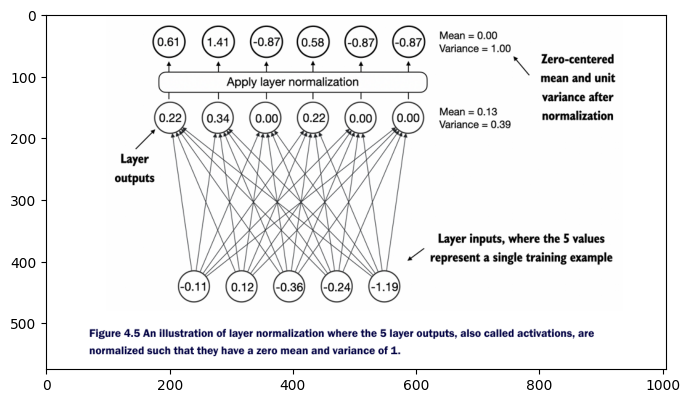

In [8]:
# 🔍 What is Layer Normalization?
# Layer Normalization is a technique that normalizes the inputs across the features for each individual example in a batch, helping with training stability and convergence.

# Without Layer Norm:
# - Training can be unstable
# - Gradients can explode or vanish
# - Slower convergence

# With Layer Norm:
# - Stable training
# - Better gradient flow
# - Faster convergence
# - Reduces internal covariate shift
import matplotlib.pyplot as plt
img=plt.imread("images/9.png")
plt.figure(figsize=(8,6))
plt.imshow(img)

In [9]:
# Lets implement
torch.manual_seed(123)
batch_example=torch.randn(2,5)
print("Input :", batch_example)
layer=nn.Sequential(nn.Linear(5,6),nn.ReLU())
out=layer(batch_example)
print("Output without LayerNorm:\n", out)

Input : tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
Output without LayerNorm:
 tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [10]:
mean=out.mean(dim=-1,keepdim=True)
var=out.var(dim=-1,keepdim=True)
#keepdim=True keeps the dimensions same for both input and output
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [11]:
out_norm=(out-mean)/torch.sqrt(var)
mean=out_norm.mean(dim=-1,keepdim=True)
var=out_norm.var(dim=-1,keepdim=True)
print("Normalized layer outputs:\n",out_norm)
print("Mean:\n",mean)
print("Variance:\n", var)


Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [12]:
torch.set_printoptions(sci_mode=False)
print("Normalized layer outputs:\n",out_norm)
print("Mean:\n",mean)
print("Variance:\n", var)
print("We finally got the layer normalization paart done successfully")

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)
We finally got the layer normalization paart done successfully


In [13]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps=1e-5
        self.scale=nn.Parameter(torch.ones(emb_dim))
        self.shift=nn.Parameter(torch.zeros(emb_dim))
    def forward(self,x):
        mean=x.mean(dim=-1,keepdim=True)
        var=x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x=(x-mean)/torch.sqrt(var+self.eps)
        return self.scale*norm_x+self.shift
"""
This code implements Layer Normalization - a technique that normalizes feature values for each input example to have mean≈0 and variance≈1,
which stabilizes training and improves model performance.
# For each position in each sequence:
# 1. Calculate mean and variance across features (emb_dim)
# 2. Normalize: (x - mean) / sqrt(variance)
# 3. Apply learnable scale and shift
"""

'\nThis code implements Layer Normalization - a technique that normalizes feature values for each input example to have mean≈0 and variance≈1,\nwhich stabilizes training and improves model performance.\n# For each position in each sequence:\n# 1. Calculate mean and variance across features (emb_dim)\n# 2. Normalize: (x - mean) / sqrt(variance)\n# 3. Apply learnable scale and shift\n'

In [ ]:
ln=LayerNorm(emb_dim=5)
out_ln=ln(batch_example)
mean=out_ln.mean(dim=-1,keepdim=True)
var=out_ln.var(dim=-1,unbiased=False,keepdim=True)
print("Mean:\n",mean)
print("Variance:\n",var)


Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<Figure size 800x600 with 0 Axes>

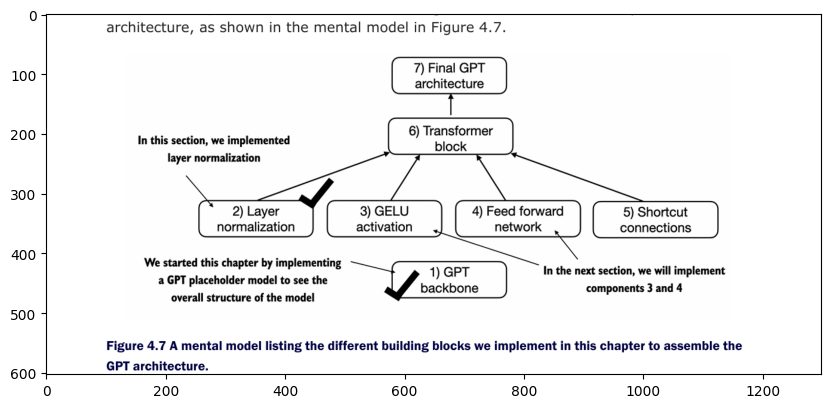

In [20]:
plt.figure(figsize=(10,12))
img=plt.imread("images/10.png")
plt.imshow(img)

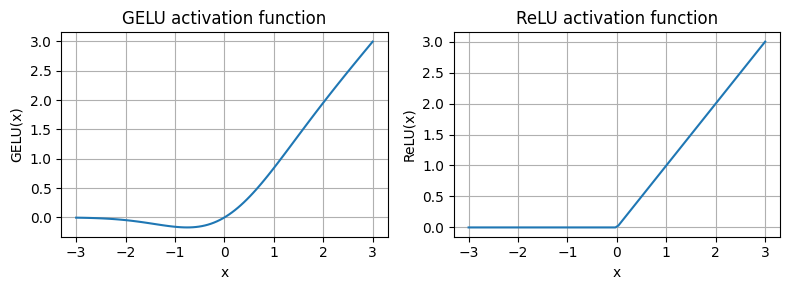

In [23]:
# Lets implement GELU score
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2/torch.pi))*(x+0.044715*torch.pow(x,3))))

# Now lets see the difference between GELU and RELU activation function and why are we using GELU insted of RELu in transformers block
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)                                    #A
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
    plt.tight_layout()
plt.show()

In [25]:
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers=nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
        )
    def forward(self,x):
        return self.layers(x)

#input and the output dimension should be same 
# 📊 Visual Representation
# Transformer Block Structure:
#
# Input: [batch, seq_len, emb_dim]
#   ↓
# Multi-Head Attention
#   ↓
# Add & Norm (Residual Connection) ← Requires same dimensions
#   ↓  
# Feed Forward Network
#   ↓
# Add & Norm (Residual Connection) ← Requires same dimensions
#   ↓
# Output: [batch, seq_len, emb_dim] ← Must match input!

## 🎯 **GPT Architecture Implementation Summary till now **

### **1. Configuration & Model Setup**
- **GPT_config_124M**: Configuration dictionary defining model hyperparameters
- **vocab_size: 50257** - Total unique tokens in vocabulary
- **context_length: 1024** - Maximum sequence length the model can process
- **emb_dim: 768** - Embedding dimension for each token representation
- **n_heads: 12** - Number of attention heads in multi-head attention
- **n_layers: 12** - Number of transformer blocks stacked together
- **drop_rate: 0.1** - 10% dropout rate for regularization
- **qkv_bias: False** - No bias terms in Query/Key/Value projections

### **2. Dummy GPT Model Architecture**
- **DummyGPTModel**: Skeleton implementation with placeholder components
- **Token Embeddings**: `nn.Embedding(vocab_size, emb_dim)` creates lookup table mapping token IDs to 768-dimensional vectors
- **Position Embeddings**: `nn.Embedding(context_length, emb_dim)` maps each position (0-1023) to learnable position vectors
- **Embedding Addition**: Token + position embeddings combined element-wise to create complete representations
- **Dropout Layer**: `nn.Dropout(0.1)` applied to embeddings for regularization during training
- **Transformer Blocks**: 12 dummy blocks currently doing pass-through (placeholder for real attention mechanisms)
- **Final Layer Norm**: Dummy normalization before output head
- **Output Head**: `nn.Linear(768, 50257)` converts embeddings to vocabulary logits for next token prediction

### **3. Data Flow Through Model**
- **Input**: Token IDs tensor of shape `[batch_size, sequence_length]`
- **Token Embedding**: Converts IDs to `[batch_size, seq_len, 768]` embeddings
- **Position Embedding**: Creates position vectors `[seq_len, 768]` broadcasted across batch
- **Combined Representation**: `tok_embeds + pos_embeds` creates context-aware token representations
- **Dropout Application**: Randomly zeros 10% of values during training for regularization
- **Transformer Processing**: Pass through 12 transformer blocks (currently dummy)
- **Final Normalization**: Layer norm applied before output projection
- **Logits Generation**: Linear projection to `[batch_size, seq_len, 50257]` vocabulary scores

### **4. Layer Normalization Implementation**
- **Purpose**: Normalizes features across embedding dimension for training stability
- **Real Implementation**: `LayerNorm` class with learnable scale and shift parameters
- **Normalization Process**: Calculate mean and variance across last dimension (features)
- **Formula**: `(x - mean) / sqrt(variance + eps)` followed by `scale * normalized + shift`
- **Benefits**: Stable training, better gradient flow, faster convergence, reduces internal covariate shift
- **Parameters**: `self.scale` (learnable γ), `self.shift` (learnable β), `self.eps` (1e-5 for numerical stability)
- **Application**: Applied to each position independently, normalizing across 768 features

### **5. GELU Activation Function**
- **Formula**: `0.5 * x * (1 + tanh(sqrt(2/π) * (x + 0.044715 * x³)))`
- **Advantages over ReLU**: Smooth, differentiable everywhere, allows small negative values
- **Usage**: Preferred in transformer architectures for better language modeling performance
- **Comparison**: Unlike ReLU's hard cutoff at zero, GELU provides smooth probabilistic activation

### **6. Feed Forward Network (FFN)**
- **Architecture**: Two linear layers with GELU activation in between
- **Expansion**: First linear layer expands from 768 to 3072 dimensions (4x expansion)
- **Activation**: GELU provides non-linearity enabling complex pattern learning
- **Contraction**: Second linear layer contracts back from 3072 to 768 dimensions
- **Input/Output Matching**: Same dimensions required for residual connections
- **Purpose**: Processes information position-wise after attention mechanisms

### **7. Why Same Input/Output Dimensions**
- **Residual Connections**: Enable `x + ffn(x)` operations requiring matching shapes
- **Layer Stacking**: 12 identical transformer blocks need consistent interfaces
- **Gradient Flow**: Skip connections help gradients flow through deep networks
- **Modular Design**: Same shape throughout enables modular, stackable architecture

### **8. Pattern Recognition Mechanism**
- **Weight Learning**: FFN learns through gradient descent on millions of text examples
- **Statistical Patterns**: Model discovers relationships like "king - man + woman ≈ queen"
- **Hierarchical Features**: Lower layers learn basic features, higher layers learn complex relationships
- **Context Disambiguation**: Learns to distinguish "bank" (financial) vs "bank" (river) based on surrounding context
- **Emergent Behavior**: Complex patterns emerge from simple mathematical operations at scale

### **9. Mathematical Foundation**
- **Not Magic**: Pure linear algebra - matrix multiplications and non-linear activations
- **Training Process**: Millions of examples → predictions → error calculation → weight updates
- **High-Dimensional Space**: 768+ dimensions enable rich representational capacity
- **Attention + FFN**: Attention gathers relevant information, FFN processes and transforms it

### **10. Implementation Status**
- **Current State**: Skeleton with dummy components (LayerNorm, TransformerBlock)
- **Real Components**: Implemented LayerNorm, GELU, FeedForward classes
- **Next Steps**: Replace dummy transformer blocks with real multi-head attention
- **Parameter Count**: ~124 million parameters matching GPT-2 small model
- **Training Ready**: Architecture complete, ready for real attention implementation

### **11. Key Technical Details**
- **Embedding Tables**: Learnable lookup tables for tokens and positions
- **Broadcasting**: Position embeddings automatically broadcast across batch dimension
- **Device Handling**: `torch.arange(seq_len, device=input.device)` ensures GPU compatibility
- **Sequential Processing**: `nn.Sequential` chains transformer blocks for easy forward pass
- **Bias Control**: `bias=False` in output head following GPT architecture specifications

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            # Implement 5 layers
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])
    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [28]:
layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
   layer_sizes, use_shortcut=False
 )

In [29]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])
    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    # Backward pass to calculate the gradients
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [30]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [ ]:
# Now lets see with model with shortcut
torch.manual_seed(123)
model_with_shortcut=ExampleDeepNeuralNetwork(layer_sizes,use_shortcut=True)
print_gradients(model_with_shortcut,sample_input)

""" In conclusion, shortcut connections are important for overcoming the limitations posed
 by the vanishing gradient problem in deep neural networks. Shortcut connections are a core
 building block of very large models such as LLMs, and they will help facilitate more effective
 training by ensuring consistent gradient flow across layers when we train the GPT model in
 the next chapter.
 After introducing shortcut connections, we will now connect all of the previously covered
 concepts (layer normalization, GELU activations, feed forward module, and shortcut
 connections) in a transformer block in the next section, which is the final building block we
 need to code the GPT architecture."""

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


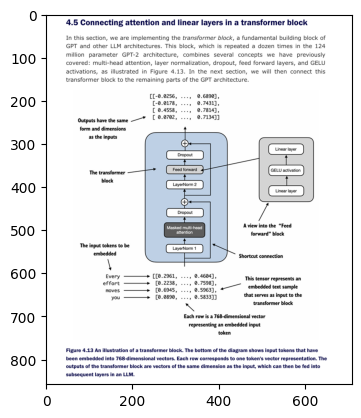

In [35]:
plt.Figure(figsize=(14,61))
img=plt.imread("images/11.png")
plt.imshow(img)

In [ ]:
#Now we have almost coded everything required for the transformer block
#Now lets combine everything to make a transformer block

In [39]:
# I copy pasted this multi head self attention class from the previous chapter 
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
                context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads                        #A
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)                   #B
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
                torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)                                      #C
        queries = self.W_query(x)                                 #C
        values = self.W_value(x)                                  #C
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) #D
        values = values.view(b, num_tokens, self.num_heads, self.head_dim) #D
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)#D
        keys = keys.transpose(1, 2)                               
        queries = queries.transpose(1, 2)                         
        values = values.transpose(1, 2)                           
        attn_scores = queries @ keys.transpose(2, 3)  #F           
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]    
        attn_scores.masked_fill_(mask_bool, -torch.inf)           
        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = (attn_weights @ values).transpose(1, 2) #I         

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)                  
        #K
        return context_vec

In [44]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.attn=MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff=FeedForward(cfg)
        self.norm1=LayerNorm(cfg["emb_dim"])
        self.norm2=LayerNorm(cfg["emb_dim"])
        self.drop_shortcut=nn.Dropout(cfg["drop_rate"])
    def forward(self,x):
        shortcut=x
        x=self.norm1(x)
        x=self.attn(x)  
        x=self.drop_shortcut(x)
        x=shortcut+x
        shortcut=x
        x=self.norm2(x)
        x=self.ff(x)
        x=self.drop_shortcut(x)
        x=shortcut+x
        return x

In [ ]:
torch.manual_seed(123)
x=torch.randn(2,4,768)
block=TransformerBlock(cfg=GPT_config_124M)
output=block(x)
print("Input Shape:",x.shape)
print("Output Shape:",output.shape)
print("Input and output shapes match:", x.shape == output.shape)
print("This confirms that the transformer block is functioning correctly, maintaining the input shape through its operations.")

Input Shape: torch.Size([2, 4, 768])
Output Shape: torch.Size([2, 4, 768])
Input and output shapes match: True
This confirms that the transformer block is functioning correctly, maintaining the input shape through its operations.


In [ ]:
# Now lets esemble all the codes into the final GPT model 
class GPT_Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb=nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb=nn.Embedding(cfg["context_length"],cfg["emb_size"])
        self.drop_emb=nn.Dropout(cfg["drop_rate"])
        self.transformers_blocks=nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm=LayerNorm(cfg["emb_dim"])
        self.out_head=nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)
    def forward(self,in_idx):
                